#### The EfficentNet model

Using effent because it should later run on edge AI device.

In [23]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 400                      # earlystopping, see model.fit
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = False                # grayscale or rgb
model_filename = "eff100-rgb.h5"

##########################################################################


### The Model

Effnet as used in distillation

In [24]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Rescaling, LayerNormalization

def get_post(x_in):
    x = LeakyReLU()(x_in)
    x = BatchNormalization()(x)
    return x

def get_block(x_in, ch_in, ch_out):
    x = Conv2D(ch_in,
               kernel_size=(1, 1),
               padding='same',
               use_bias=False)(x_in)
    x = get_post(x)

    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = get_post(x)
    x = MaxPool2D(pool_size=(2, 1),
                  strides=(2, 1))(x) # Separable pooling

    x = DepthwiseConv2D(kernel_size=(3, 1),
                        padding='same',
                        use_bias=False)(x)
    x = get_post(x)

    x = Conv2D(ch_out,
               kernel_size=(2, 1),
               strides=(1, 2),
               padding='same',
               use_bias=False)(x)
    x = get_post(x)

    return x


def Effnet(input_shape, nb_classes, include_top=True, weights=None, activation_top=None):
    x_in = Input(shape=input_shape)

    x = get_block(x_in, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        x = Dense(nb_classes, activation=activation_top)(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model



### Class Encoding

To ensure the values are enumerated from 0.0 - 9.9 in categorical and can be used in the C++ code later with argmax() / 10.0, encoding and decoding functions will be used.

In [25]:
import tensorflow.keras as keras
import math
import numpy as np

def class_encoding(y_train, nb_classes):
    '''like to_categorical.
        y_train must be an array
        nb_classes for the class count, if not all values in y_train
    '''
    ret = np.zeros((len(y_train), nb_classes))
    for i, y in enumerate(y_train):
        ret[i, int((y*10))] = 1
    return ret

def class_decoding(y_train, nb_classes=100):
    ''' from_categorical like function. It returns a float value between 0.0 and 9.9
        y_train the encoded values in an array
        nb_classes should be ignored. will not used
    '''
    ret = np.zeros((len(y_train), 1))
    for i, y in enumerate(y_train):
        ret[i] = (np.argmax(y))/10
    return ret

#### Augmentation functions

The augmentation of train data uses 
* width shift
* no height shift
* random brightness
* random rotation
* rgb channel shift
* random shear
* random invert of the images
* random spot light (led reflections)
* random noising 

So the font dataset looks more like a meter digit and the augmentation prevents overfitting.

In [26]:
import numpy as np
from scipy.stats import norm
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 3
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


## https://medium.com/@fanzongshaoxing/adjust-local-brightness-for-image-augmentation-8111c001059b
def generate_spot_light_mask(mask_size,
                             position=None,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             linear_decay_rate=None,
                             speedup=False):
    """
    Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: list of tuple of integers (x, y) defining the center of spotlight light position,
                  which is the reference point during rotating
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
        speedup: use `shrinkage then expansion` strategy to speed up vale calculation
    Return:
        light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                    minimum value could be smaller than given min_brightness.
    """
    if position is None:
        position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.25, 1)
    assert mode in ["linear", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
    if mode == "gaussian":
        mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
        dev = mu / 3.5
        mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 5)
    mask = 255 - mask
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)
    return mask

def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):
    """
    _decay_value_radically_norm function in matrix format
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = np.zeros((mask_size[1], mask_size[0]))
    for center in centers:
        coord_x = np.arange(mask_size[0])
        coord_y = np.arange(mask_size[1])
        xv, yv = np.meshgrid(coord_x, coord_y)
        dist_x = xv - center[0]
        dist_y = yv - center[1]
        dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
        x_value_rate += norm.pdf(dist, 0, dev) / center_prob
    mask = x_value_rate * (max_value - min_value) + min_value
    mask[mask > 255] = 255
    return mask



def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):
    """
    Add mask generated from spot light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.2, 0.75)
    frame = image
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame



def invert(imagem):
    if (random.getrandbits(1)):
        return (255)-imagem
    else:
        return imagem

def blur(img):
    k = random.randint(0,3)
    if (k>0):
        return (cv2.blur(img,(3,3)))
    else:
        return img

def preprocessing(img):
    #if (random.getrandbits(1)):
    #    img = blur(img)
    if (random.getrandbits(1)):
        img = add_spot_light(img).astype(np.float32)
    img = invert(img)
    img = add_noise(img)
    
    return img



Width_Shift_Range = 3 # px
Height_Shift_Range = 0 # px
Brightness_Range = [0.4,1.2]
Rotation_Angle = 5
ZoomRange_Out = 0.1
ZoomRange_In = 0.1
ShearRange= 3
Channel_Shift=0.4


def augmentation(x, y, Batch_Size = 32):
    datagen = ImageDataGenerator(width_shift_range=Width_Shift_Range, 
                             height_shift_range=Height_Shift_Range,
                             brightness_range=Brightness_Range,
                             #zoom_range=[1-ZoomRange_In, 1+ZoomRange_Out],
                             rotation_range=Rotation_Angle,
                             channel_shift_range=Channel_Shift,
                             fill_mode='nearest',
                             shear_range=ShearRange
                             ,preprocessing_function=preprocessing
                             ,dtype=float)
    #datagen.fit(x)
    return datagen.flow(x, y, batch_size=Batch_Size)
    
def no_augmentation(x, y, Batch_Size = 32):
    datagen = ImageDataGenerator(dtype=float)
    return datagen.flow(x, y, batch_size=Batch_Size)


#### Plot functions

Various plot functions for image plottings and loss/accuracy plots

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.xticks([0.2, 0.4, 0.6, 0.8])
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1.6', extent=[0, 1, 0, 1])
        # yellow lines
        for y in np.arange(0.2, 0.8, 0.2):
            plt.axhline(y=y,color='yellow')
        ax=plt.gca()
        ax.get_xaxis().set_visible(False) 
        plt.tight_layout()
    plt.show()

def plot_dataset_it(data_iter, columns=9, rows=5):

    fig = plt.figure(figsize=(18, 11))
    
    for i in range(1, columns*rows +1):
        img, label = data_iter.next()
        fig.add_subplot(rows, columns, i)
        plt.xticks([0.2, 0.4, 0.6, 0.8])
        plt.title(str(class_decoding(label[0].reshape(-1, nb_classes), nb_classes).reshape(-1)[0]))  # set title
        plt.imshow(img[0].astype(np.uint8), aspect='1.6', extent=[0, 1, 0, 1])
        ax=plt.gca()
        ax.get_xaxis().set_visible(False) 
        # yellow lines
        for y in np.arange(0.2, 0.8, 0.2):
                plt.axhline(y=y,color='yellow')
    plt.show()

def plot_acc_loss(history, modelname="modelname"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(modelname)
    fig.set_figwidth(15)

    if "loss" in history.history:
        ax1.plot(history.history['loss'])
    if "accuracy" in history.history:
        ax2.plot(history.history['accuracy'])
    if "val_loss" in history.history:
        ax1.plot(history.history['val_loss'])
    if "val_accuracy" in history.history:
        ax2.plot(history.history['val_accuracy'])
    if "student_loss" in history.history:
        ax1.plot(history.history['student_loss'])
    if "sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['sparse_categorical_accuracy'])
    if "val_sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['val_sparse_categorical_accuracy'])
    if "student_accuracy" in history.history:
        ax2.plot(history.history['student_accuracy'])
    if "val_student_accuracy" in history.history:
        ax2.plot(history.history['val_student_accuracy'])
    if "distillation_loss" in history.history:
        ax1.plot(history.history['distillation_loss'])

    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax1.legend(['train','eval'], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.92,1])
    plt.show()


def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    return fig


def confusion_matrix(predicted, y_test, nb_classes):
    ytrue = pd.Series(y_test.reshape(-1), name = 'actual')
    ypred = pd.Series(predicted.reshape(-1), name = 'pred')
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('max_colwidth', None)
    return pd.crosstab(ytrue, ypred)


def predict_meter_digits():
    import numpy as np
    from tensorflow import keras

    max_delta = 0.11

    predictions = class_decoding(model.predict(xz_data.astype(np.float32)), 100).reshape(-1)

    # 9.9 <> 0 = 0.1 and 1.1 <> 1.2 = 0.1
    differences = np.minimum(np.abs(predictions-yz_data), np.abs(predictions-(10-yz_data)))

    # used for filtering
    false_differences = differences>max_delta

    # only differences bigger than delta. so small differences can be ignored in early stages
    false_predicted = differences[false_differences]
    false_images = xz_data[false_differences]
    false_labels = [ "Expected: " + str(y) + "\n Predicted: " + str(p) + "\n" + str(f)[-26:-4] for y, p, f in zip(yz_data[false_differences], predictions[false_differences], fz_data[false_differences])]

    print(f"Tested images: {len(yz_data)}. {len(false_predicted)} false predicted. Accuracy is: {1-len(false_predicted)/len(yz_data)}")

    # plot the differences (max difference can only be 5.0)
    plot_divergence(np.bincount(np.array(false_predicted*10).astype(int), minlength=51), "Divergation of false predicted", 51)

    # plot the false predicted images
    plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))

#### Data loading function TMNIST

The Type face MNIST dataset comes from kaggle and is processed for percental digits. 

The complete dataset has 300.000 images. Some fonts are not good for train the meter digits and will be removed by blacklist entries.

In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

def tmnist_percentals():
    y_train = np.empty((0))
    x_train = np.empty((0, 32, 20,3))
    
    # fonts in blacklist will be removed from dataset
    blacklist_url = "datasets/font-blacklist.txt"
    blacklist_data = pd.read_csv(blacklist_url, index_col=False)
    
    for i in range(28):

        dataset_url = "datasets/TMNIST_PERCENTAL_"+str((i+1)*1000)+"_Data.csv"
        data = pd.read_csv(dataset_url, index_col=False)
        data = data.drop(data[data['names'].isin(blacklist_data.values.reshape(-1))].index)
        
        y_tmnist = data[['labels']]
        
        X = data.drop({'labels','names'},axis=1)

        # resizing needs a new shape
        X_images = (X.values.reshape(-1,28,28,1))
        
        # resize but not all for padding
        X_images = tf.image.resize(X_images, (30,22))
        
        # now pad to make a border (later white)
        # so it looks more like a meter digit
        X_images = tf.image.resize_with_pad(X_images, 32, 20)
        
        # remove the shape for resizing
        X_images = np.array(X_images).reshape(-1,32,20)
        # gray to rgb (split in 3 channels)
        X_images = np.stack((X_images,)*3, axis=-1)
        
        x_train = np.concatenate((X_images, x_train))
        y_train = np.concatenate((y_tmnist.values.reshape(-1), y_train))
    
    return shuffle(x_train,  y_train, n_samples=len(y_train))



In [29]:
import os
import shutil
from PIL import Image 
from tensorflow import keras

def ziffer_data_files(input_dir):
    imgfiles = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if (file.endswith(".jpg") and not file.startswith("10_") and not file.startswith("N")):
                #print(root + "/" + file)
                imgfiles.append(root + "/" + file)
    return  imgfiles

def ziffer_data(input_dir='images'):
    
    files = ziffer_data_files(input_dir)
    
    y_data = np.empty((len(files)))
    y_file = np.empty((len(files)), dtype="S100")
    x_data = np.empty((len(files),32,20,3))

    for i, aktfile in enumerate(files):
        base = os.path.basename(aktfile)

        # get label from filename (1.2_ new or 1_ old),
        if (base[1]=="."):
            target = base[0:3]
        else:
            target = base[0:1]
         
        category = float(target)
        
        test_image = Image.open(aktfile).resize((20, 32))
        test_image = np.array(test_image, dtype="float32")
        y_file[i] =  base
        x_data[i] = test_image
        y_data[i] =  category
    print("Ziffer data count: ", len(y_data))   
    return x_data, y_data, y_file


#### 

### Load data

Like the distillation network meter digits will be trained with font builded images.

The meter digits are all 0-9 ziffer_raw + my own data 0-9. 
At now no images used between two digits. Many images from 0-9 are +/- 0.2 devergent and not correctly labeled. (See the last result)

Ziffer data count:  8340
(221481, 32, 20, 3)
dataset x_train-size=221481


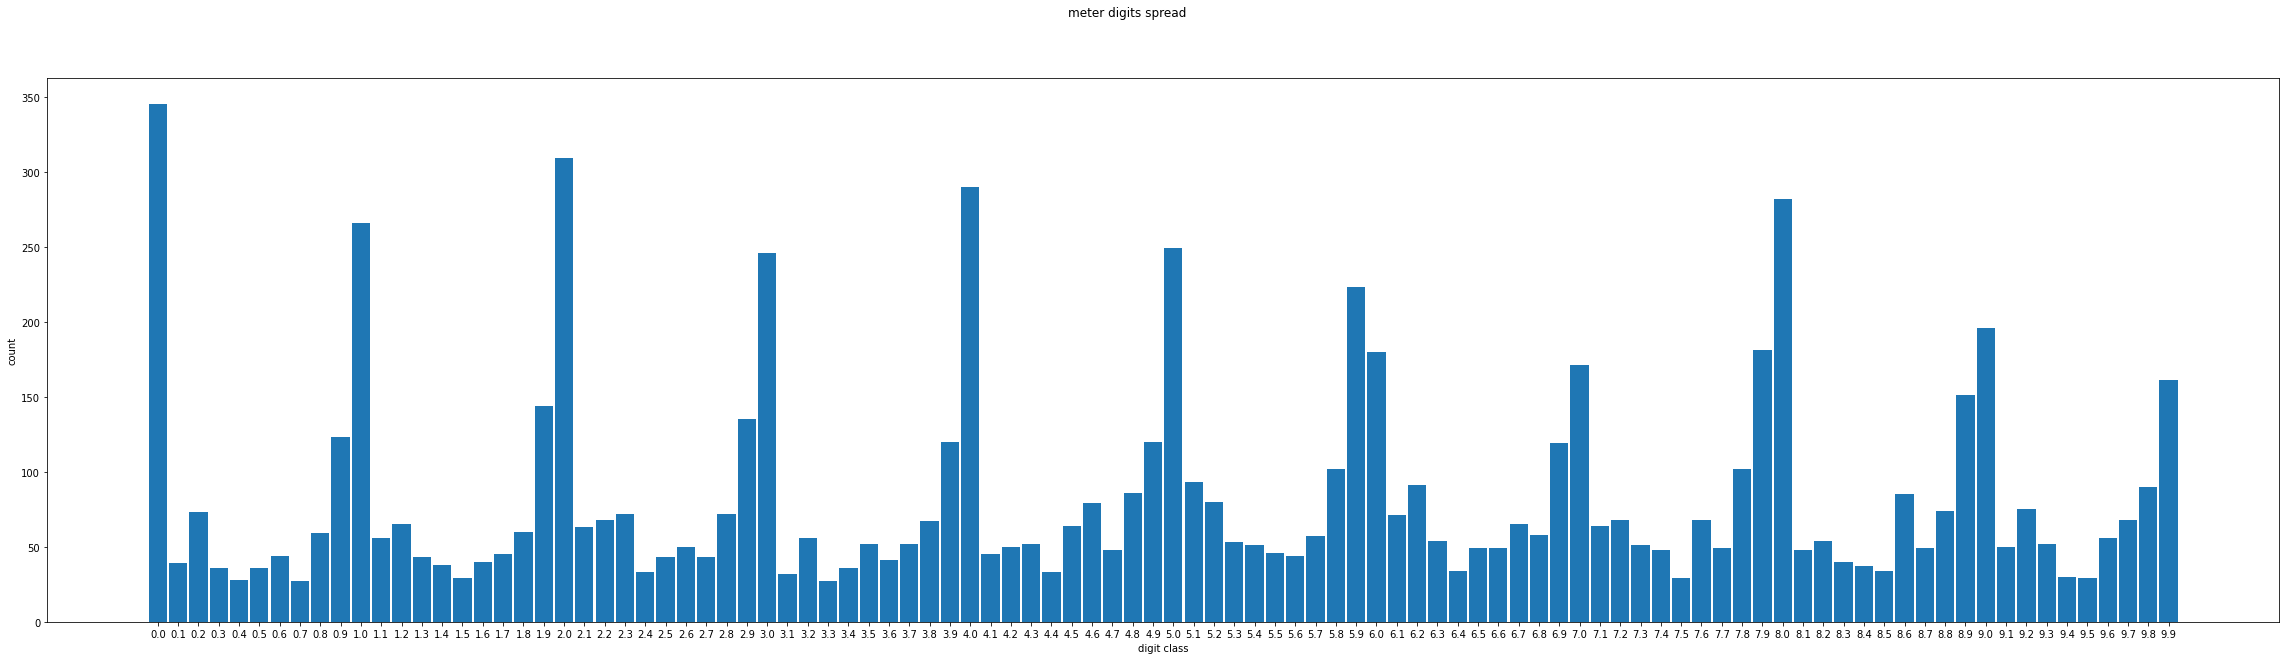

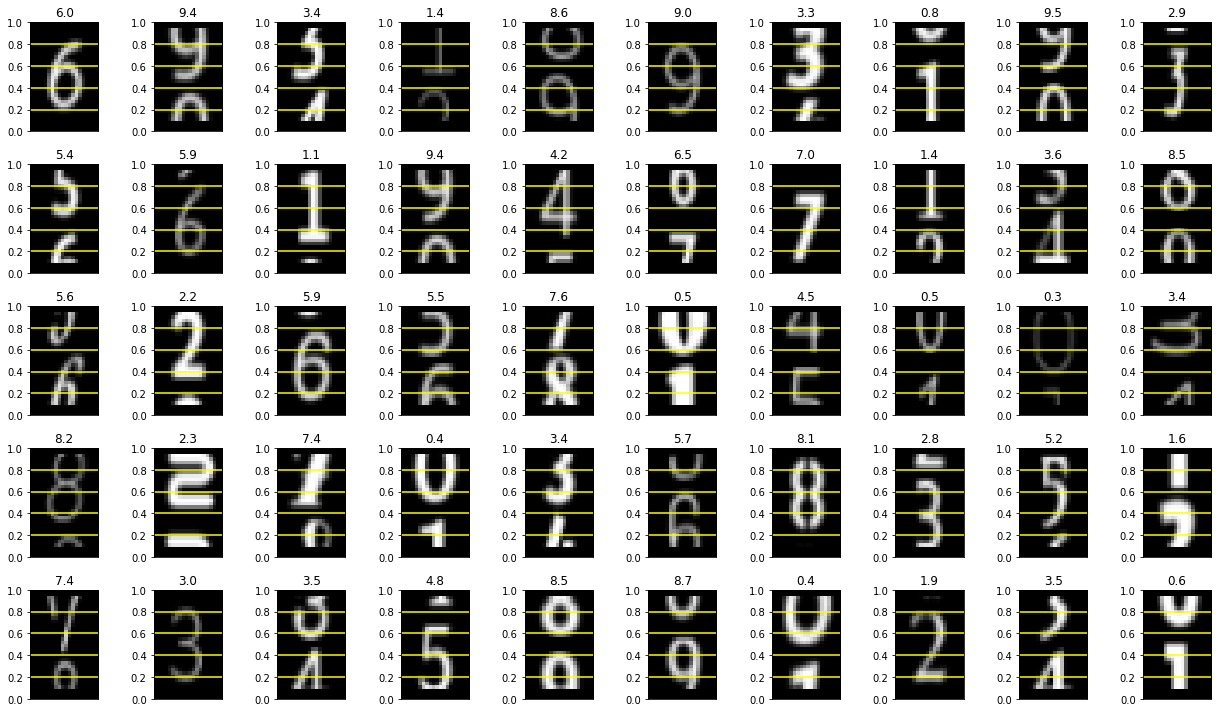

In [30]:
from sklearn.model_selection import train_test_split

xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", nb_classes)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
xz_train, xz_test, yz_train, yz_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)


xt_data, yt_data = tmnist_percentals()


x_data = np.concatenate((xt_data, xz_train))
y_data = np.concatenate((yt_data, yz_train))
x_data, y_data = shuffle(x_data, y_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

print(x_train.shape)

input_shape=x_train[0].shape
print(f"dataset x_train-size={len(x_train)}")
plot_dataset(x_train, y_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)

yz_train = class_encoding(yz_train, nb_classes)
yz_test = class_encoding(yz_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting, spot light and noising images.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

Train data


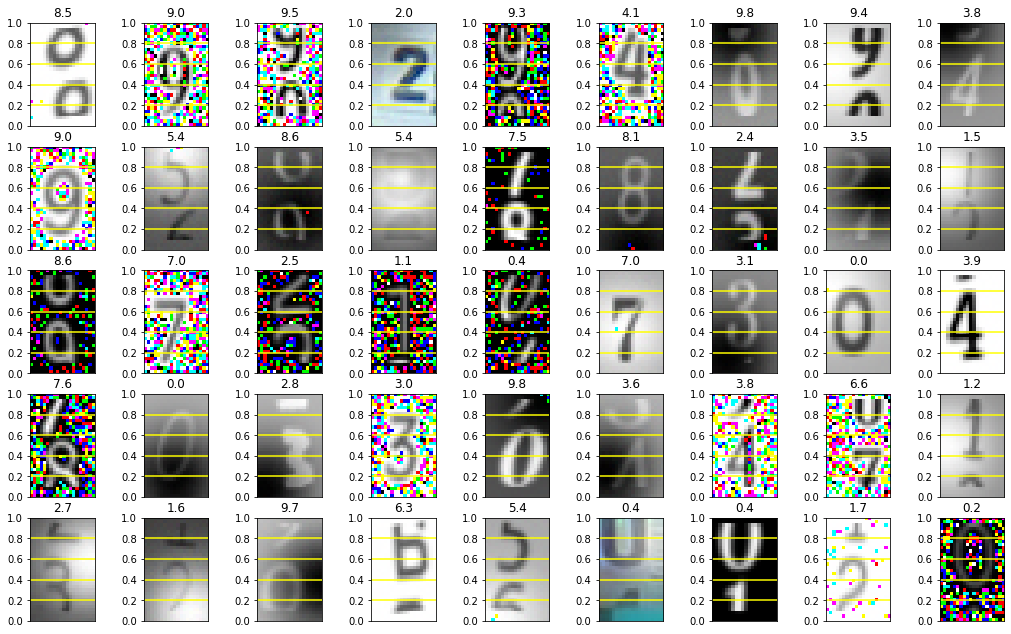

Validation data


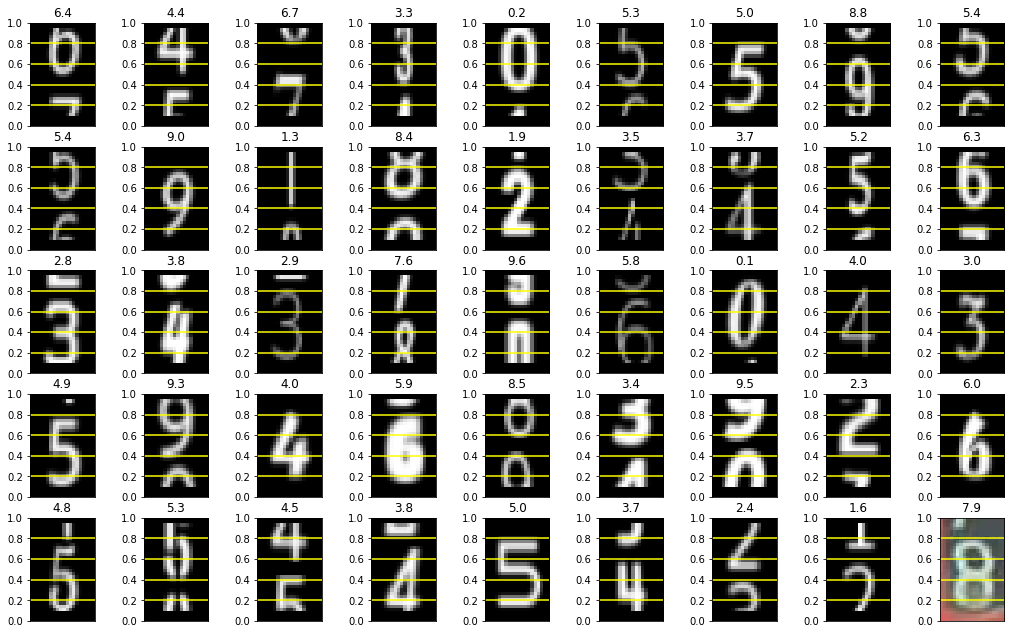

In [31]:
import numpy as np

train_iterator = augmentation(x_train, y_train)
validation_iterator = no_augmentation(x_test, y_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 



In [32]:
import tensorflow as tf

model = Effnet(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

In [33]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=50, verbose=1, baseline=0.04, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[annealer, earlystop, mc],
                verbose=1)

plot_acc_loss(history, "Trainingsresults")

model.save(model_filename)

predict_meter_digits()

Epoch 1/400


2022-06-03 17:39:50.530106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6919/6922 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8995

2022-06-03 17:41:37.210929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.96921, saving model to best_model.h5
6922/6922 [==============================] - 120s 17ms/step - loss: 0.4094 - accuracy: 0.8995 - val_loss: 0.1308 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 2/400
6920/6922 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9611
Epoch 2: val_accuracy improved from 0.96921 to 0.97585, saving model to best_model.h5
6922/6922 [==============================] - 120s 17ms/step - loss: 0.1418 - accuracy: 0.9611 - val_loss: 0.0871 - val_accuracy: 0.9759 - lr: 9.8000e-04
Epoch 3/400
6920/6922 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9700
Epoch 3: val_accuracy improved from 0.97585 to 0.97795, saving model to best_model.h5
6922/6922 [==============================] - 120s 17ms/step - loss: 0.1051 - accuracy: 0.9700 - val_loss: 0.0780 - val_accuracy: 0.9779 - lr: 9.6040e-04
Epoch 4/400
6921/6922 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy:

KeyboardInterrupt: 

In [ ]:
import numpy as np

model = keras.models.load_model('best_model.h5')

# now whith meter digits
train_iterator = augmentation(xz_train, yz_train)
validation_iterator = no_augmentation(xz_test, yz_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 

keras.models.load_model('best_model.h5')

# only the last layer is now trainable
for layer in model.layers[:-1]:
    layer.trainable=False

mc = ModelCheckpoint('best_transfermodel.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[annealer, earlystop, mc],
                verbose=1)

plot_acc_loss(history, "Trainingsresults")

model.save("transfer-" + model_filename)

predict_meter_digits()

In [ ]:
mc = ModelCheckpoint('best_fine-transfermodel.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
annealer = LearningRateScheduler(lambda x: 1e-5 * 0.98 ** x, verbose=0)

# only the last layer is now trainable
for layer in model.layers[:-1]:
    layer.trainable=True


model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = 60,
                callbacks=[annealer, earlystop, mc],
                verbose=1)

plot_acc_loss(history, "Trainingsresults")

model.save("transferfine-" + model_filename)

### Ziffer images

The model is build for predicting meter digit images (Ziffer). So we test *all* meter digit images of the dataset (not only the validation set)

max_delta can set a value, that ignored convergence +/- of the value and accept it as predicted correctly.

Because of the meter digit dataset (only 0.0, 1.0, ... 9.0) We have no real answer how good the images between two digits are predicted.

In [ ]:
import numpy as np
from tensorflow import keras

max_delta = 0.11

predictions = class_decoding(model.predict(xz_data.astype(np.float32)), 100).reshape(-1)

# 9.9 <> 0 = 0.1 and 1.1 <> 1.2 = 0.1
differences = np.minimum(np.abs(predictions-yz_data), np.abs(predictions-(10-yz_data)))

# used for filtering
false_differences = differences>max_delta

# only differences bigger than delta. so small differences can be ignored in early stages
false_predicted = differences[false_differences]
false_images = xz_data[false_differences]
false_labels = [ "Expected: " + str(y) + "\n Predicted: " + str(p) + "\n" + str(f)[-26:-4] for y, p, f in zip(yz_data[false_differences], predictions[false_differences], fz_data[false_differences])]

print(f"Tested images: {len(yz_data)}. {len(false_predicted)} false predicted. Accuracy is: {1-len(false_predicted)/len(yz_data)}")

# plot the differences (max difference can only be 5.0)
plot_divergence(np.bincount(np.array(false_predicted*10).astype(int), minlength=51), "Divergation of false predicted", 51)

# plot the false predicted images
plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))
